# Notebook for analysing the synthetic data generated by the QCBM

In [292]:
import pennylane as qml
from pennylane import numpy as pnp
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import arch

In [293]:
params_file = 'params_brnt_4.csv'

In [294]:
total_qubits = 13
layers = 7
dev = qml.device("default.qubit", wires=total_qubits)

Params300 - qubits: 11 layers: 7 

Params_Patrick - qubits: 13 layers: 7 

Params_brent - qubits: 10 layers: 8
 
Params_brent_4 - qubits: 13 layers: 7

In [295]:
def brick_ansatz(params):
    """Standard Brick QCBM ."""
    for l in range(layers):
        for i in range(total_qubits):
            qml.RX(params[l, i, 0], wires=i)
            qml.RY(params[l, i, 1], wires=i)
            qml.RZ(params[l, i, 2], wires=i)
        for i in range(total_qubits - 1):  
            qml.CNOT(wires=[i, i + 1])  
    return qml.probs(wires=range(total_qubits))

def butterfly_ansatz(params):
    """Butterfly Ansatz."""
    for l in range(layers):
        for i in range(total_qubits):
            qml.RX(params[l, i, 0], wires=i)
            qml.RY(params[l, i, 1], wires=i)
            qml.RZ(params[l, i, 2], wires=i)
        
        step = 1
        while step < total_qubits:  # Logarithmic-depth entanglement pattern
            for i in range(0, total_qubits - step, 2 * step):
                qml.CNOT(wires=[i, i + step])
            step *= 2
    return qml.probs(wires=range(total_qubits))


def pyramid_ansatz(params):
    """Pyramid Ansatz: Progressive entanglement """
    for l in range(layers):
        for i in range(total_qubits):
            qml.RX(params[l, i, 0], wires=i)
            qml.RY(params[l, i, 1], wires=i)
            qml.RZ(params[l, i, 2], wires=i)

        # Progressive entanglement: more CNOTs as depth increases
        step = 1
        for _ in range(l + 1):  # Increase connectivity as layers grow
            for i in range(0, total_qubits - step, 2 * step):
                qml.CNOT(wires=[i, i + step])
            step *= 2  # Increase entanglement range per layer
    return qml.probs(wires=range(total_qubits))

def tree_ansatz(params):
    """Binary Tree Entanglement ansatz"""
    for l in range(layers):
        for i in range(total_qubits):
            qml.RX(params[l, i, 0], wires=i)
            qml.RY(params[l, i, 1], wires=i)
            qml.RZ(params[l, i, 2], wires=i)
        step = 1
        while step < total_qubits:  # Hierarchical CNOT entanglement
            for i in range(0, total_qubits - step, 2 * step):
                qml.CNOT(wires=[i, i + step])
            step *= 2
    return qml.probs(wires=range(total_qubits))

def star_ansatz(params):
    """Star entanglement ansatz with a central hub qubit."""
    hub = 0  # Central qubit
    for l in range(layers):
        for i in range(total_qubits):
            qml.RX(params[l, i, 0], wires=i)
            qml.RY(params[l, i, 1], wires=i)
            qml.RZ(params[l, i, 2], wires=i)
        for i in range(1, total_qubits):  # Hub qubit connects to all others
            qml.CNOT(wires=[hub, i])
    return qml.probs(wires=range(total_qubits))



@qml.qnode(dev, diff_method="parameter-shift")
def quantum_model(params):
    return brick_ansatz(params)


In [296]:
def load_params(file_path):
    params_df = pd.read_csv(file_path)
    return pnp.array(params_df.values).reshape(layers, total_qubits, 3)

params = load_params(params_file)


def load_and_preprocess_data(file_path):
    data = pd.read_csv(file_path)
    prices = pd.to_numeric(data['Price'].str.replace(',', ''), errors='coerce').dropna().values 
    if len(prices) == 0:
        raise ValueError("No valid price data found in the CSV file.")
    log_returns = np.diff(np.log(prices))
    if len(log_returns) == 0:
        raise ValueError("Log returns array is empty.")
    bins = np.linspace(min(log_returns), max(log_returns), 2**total_qubits)
    return log_returns, np.digitize(log_returns, bins) - 1, bins

def load_and_preprocess_data(file_path):
    data = pd.read_csv(file_path)
    
    # Ensure the 'Price' column is treated as a string
    data['Price'] = data['Price'].astype(str)
    
    # Remove commas and convert to numeric values
    prices = pd.to_numeric(data['Price'].str.replace(',', ''), errors='coerce').dropna().values
    
    if len(prices) == 0:
        raise ValueError("No valid price data found in the CSV file.")
    
    log_returns = np.diff(np.log(prices))
    
    if len(log_returns) == 0:
        raise ValueError("Log returns array is empty.")
    
    bins = np.linspace(min(log_returns), max(log_returns), 2**total_qubits)
    return log_returns, np.digitize(log_returns, bins) - 1, bins



log_returns, training_data, bins = load_and_preprocess_data('brnt_data.csv')

def generate_synthetic_log_returns(params, bins, steps=100):
    quantum_probs = quantum_model(params)
    sampled_indices = np.random.choice(len(quantum_probs), p=quantum_probs, size=steps)
    return bins[sampled_indices]



In [297]:
mjd_data = pd.read_csv('mjd_log_returns.csv')
print(mjd_data)

             0
0    -0.037748
1    -0.005051
2     0.006257
3     0.035152
4    -0.029844
...        ...
2550 -0.015917
2551 -0.003433
2552 -0.001925
2553  0.001015
2554  0.005468

[2555 rows x 1 columns]


In [298]:
test_data = load_and_preprocess_data("brnt_data_test.csv")[0]

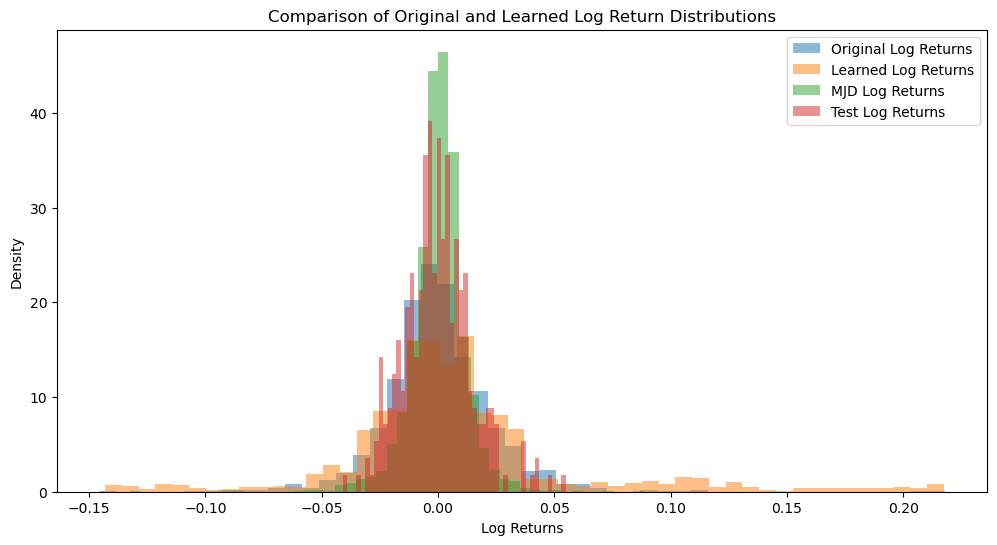

In [299]:
synthetic_log_returns = generate_synthetic_log_returns(load_params(params_file), bins, len(log_returns))

plt.figure(figsize=(12, 6))
plt.hist(log_returns, bins=50, alpha=0.5, label='Original Log Returns', density=True)
plt.hist(synthetic_log_returns, bins=50, alpha=0.5, label='Learned Log Returns', density=True)
plt.hist(mjd_data,bins=50,alpha=0.5,label='MJD Log Returns',density=True)
plt.hist(test_data, bins=50, alpha=0.5, label='Test Log Returns', density=True)
plt.xlabel('Log Returns')
plt.ylabel('Density')
plt.title('Comparison of Original and Learned Log Return Distributions')
plt.legend()
plt.show()

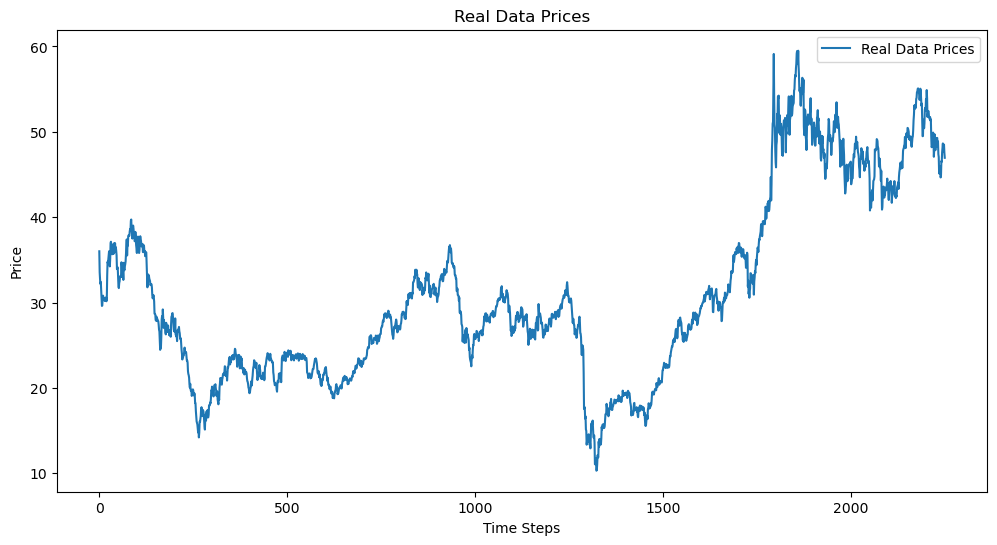

In [300]:
data = pd.read_csv('brnt_data.csv')
#prices = pd.to_numeric(data['Price'].str.replace(',', ''), errors='coerce').dropna().values
data['Price'] = data['Price'].astype(str) 
prices = pd.to_numeric(data['Price'].str.replace(',', ''), errors='coerce').dropna().values
prices = prices[::-1]
plt.figure(figsize=(12, 6))
plt.plot(prices, label='Real Data Prices')
plt.xlabel('Time Steps')
plt.ylabel('Price')
plt.title('Real Data Prices')
plt.legend()
plt.show()

In [301]:
def simulate_path(params, bins, steps=100, start_value=100):
    log_returns = generate_synthetic_log_returns(params, bins, steps)
    S = np.zeros(steps)
    S[0] = 30
    for t in range(1, steps):
        S[t] = S[t - 1] * np.exp(log_returns[t])
    return S

def propagate_process(params, bins, num_paths=10, steps=100):
    paths = []
    for _ in range(num_paths):
        path = simulate_path(params, bins, steps)
        paths.append(path)
    return np.array(paths)


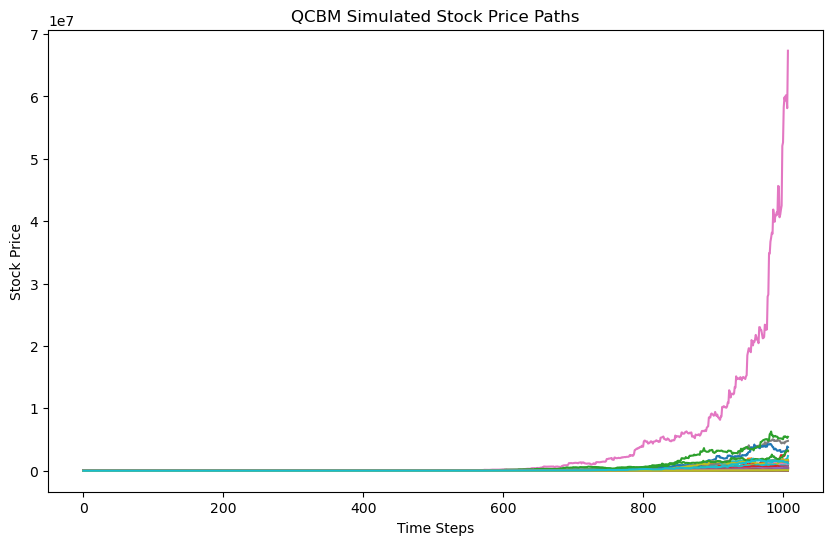

In [302]:
num_paths = 100
steps = 252*4
paths = propagate_process(params, bins, num_paths, steps)


plt.figure(figsize=(10, 6))
for i, path in enumerate(paths):
    plt.plot(path, label=f'Path {i+1}')
plt.xlabel('Time Steps')
plt.ylabel('Stock Price')
plt.title('QCBM Simulated Stock Price Paths')
plt.show()

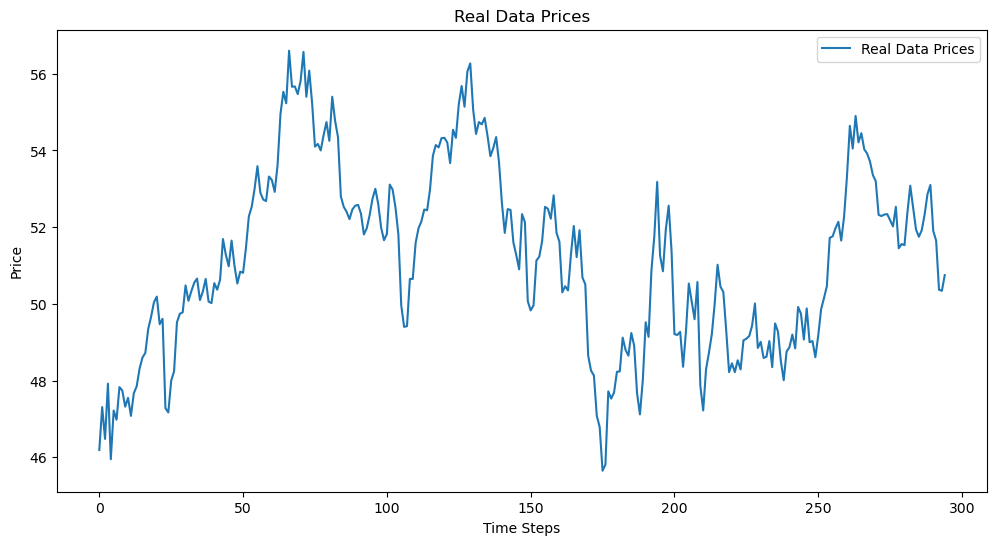

In [303]:
data = pd.read_csv('brnt_data_test.csv')
data['Price'] = data['Price'].astype(str)
prices = pd.to_numeric(data['Price'].str.replace(',', ''), errors='coerce').dropna().values 
prices = prices[::-1]
plt.figure(figsize=(12, 6))
plt.plot(prices, label='Real Data Prices')
plt.xlabel('Time Steps')
plt.ylabel('Price')
plt.title('Real Data Prices')
plt.legend()
plt.show()

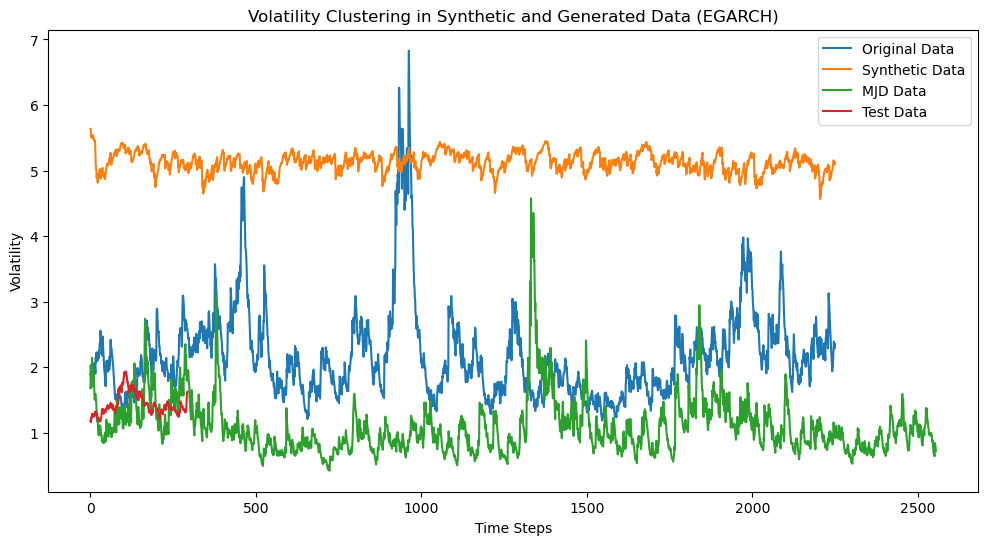

In [304]:
rescaled_log_returns = log_returns * 100
rescaled_synthetic_log_returns = synthetic_log_returns * 100
rescaled_mjd_data = mjd_data * 100
rescaled_test_data = test_data * 100

original_egarch = arch.arch_model(rescaled_log_returns, vol='EGARCH', p=1, q=1)
original_fit = original_egarch.fit(disp='off')
original_volatility = original_fit.conditional_volatility

synthetic_egarch = arch.arch_model(rescaled_synthetic_log_returns, vol='EGARCH', p=1, q=1)
synthetic_fit = synthetic_egarch.fit(disp='off')
synthetic_volatility = synthetic_fit.conditional_volatility

test_egarch = arch.arch_model(rescaled_test_data, vol='EGARCH', p=1, q=1)
test_fit = test_egarch.fit(disp='off')
test_volatility = test_fit.conditional_volatility

mjd_egarch = arch.arch_model(rescaled_mjd_data, vol='EGARCH', p=1, q=1)
mjd_fit = mjd_egarch.fit(disp='off')
mjd_volatility = mjd_fit.conditional_volatility

plt.figure(figsize=(12, 6))
plt.plot(original_volatility, label='Original Data')
plt.plot(synthetic_volatility, label='Synthetic Data')
plt.plot(mjd_volatility,label='MJD Data')
plt.plot(test_volatility, label='Test Data')
plt.xlabel('Time Steps')
plt.ylabel('Volatility')
plt.title('Volatility Clustering in Synthetic and Generated Data (EGARCH)')
plt.legend()
plt.show()

                     Constant Mean - GARCH Model Results                      
Dep. Variable:                      y   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -4854.52
Distribution:                  Normal   AIC:                           9721.04
Method:            Maximum Likelihood   BIC:                           9755.35
                                        No. Observations:                 2250
Date:                Fri, Feb 28 2025   Df Residuals:                     2249
Time:                        23:02:45   Df Model:                            1
                                Mean Model                                
                 coef    std err          t      P>|t|    95.0% Conf. Int.
--------------------------------------------------------------------------
mu            -0.0707  4.416e-02     -1.602      0.109 [ -0.157,

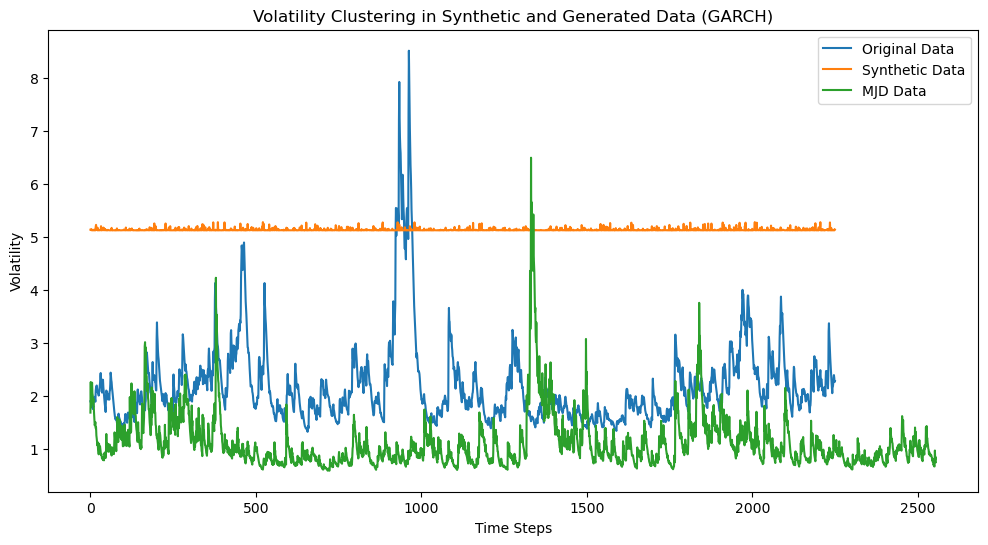

In [305]:
original_garch = arch.arch_model(rescaled_log_returns, vol='GARCH', p=2, q=2)
original_fit = original_garch.fit(disp='off')
print(original_fit.summary())
original_volatility = original_fit.conditional_volatility

synthetic_garch = arch.arch_model(rescaled_synthetic_log_returns, vol='GARCH', p=2, q=2)
synthetic_fit = synthetic_garch.fit(disp='off')
print(synthetic_fit.summary())
synthetic_volatility = synthetic_fit.conditional_volatility

mjd_garch = arch.arch_model(rescaled_mjd_data, vol='GARCH', p=2, q=2)
mjd_fit = mjd_garch.fit(disp='off')
print(mjd_fit.summary())
mjd_volatility = mjd_fit.conditional_volatility

plt.figure(figsize=(12, 6))
plt.plot(original_volatility, label='Original Data')
plt.plot(synthetic_volatility, label='Synthetic Data')
plt.plot(mjd_volatility,label='MJD Data')
plt.xlabel('Time Steps')
plt.ylabel('Volatility')
plt.title('Volatility Clustering in Synthetic and Generated Data (GARCH)')
plt.legend()
plt.show()

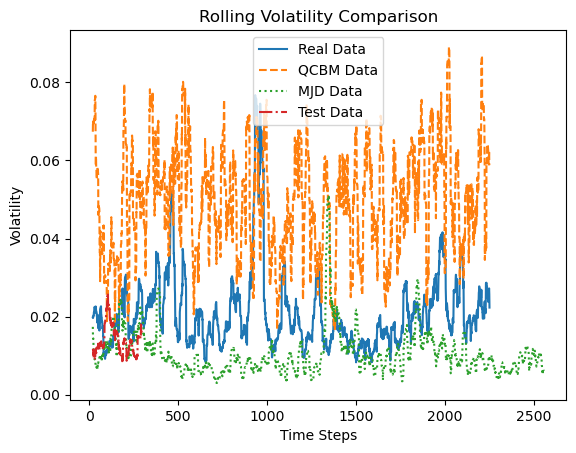

In [306]:
def rolling_volatility(log_returns, window=20):
    return pd.Series(log_returns).rolling(window).std().reset_index(drop=True)

vol_real = rolling_volatility(log_returns)
vol_qcbm = rolling_volatility(synthetic_log_returns)
vol_mjd = rolling_volatility(mjd_data.values.flatten())
vol_test = rolling_volatility(test_data)

vol_real.plot(label="Real Data")
vol_qcbm.plot(label="QCBM Data", linestyle="dashed")
vol_mjd.plot(label="MJD Data", linestyle="dotted")
vol_test.plot(label="Test Data", linestyle="dashdot")
plt.title("Rolling Volatility Comparison")
plt.xlabel("Time Steps")
plt.ylabel("Volatility")
plt.legend()
plt.show()


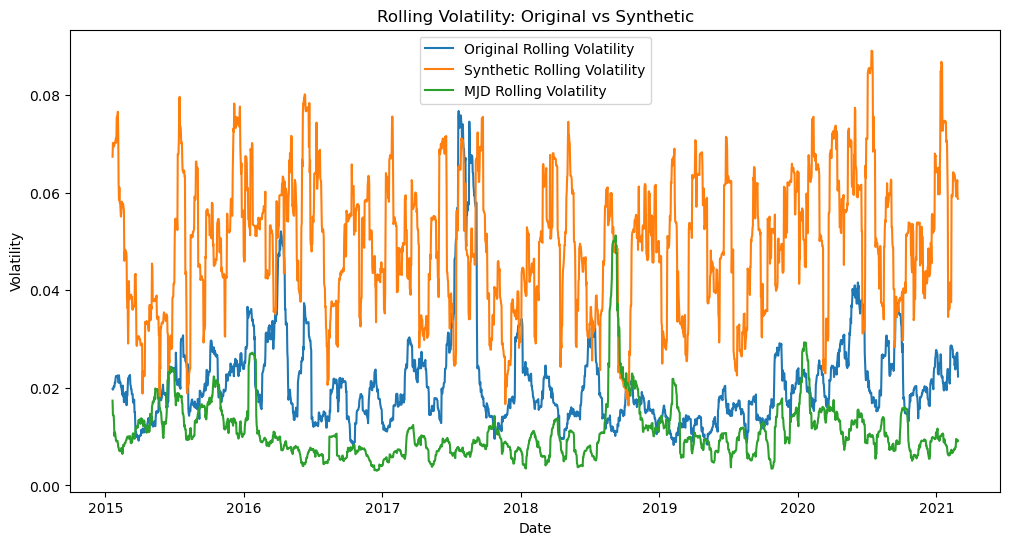

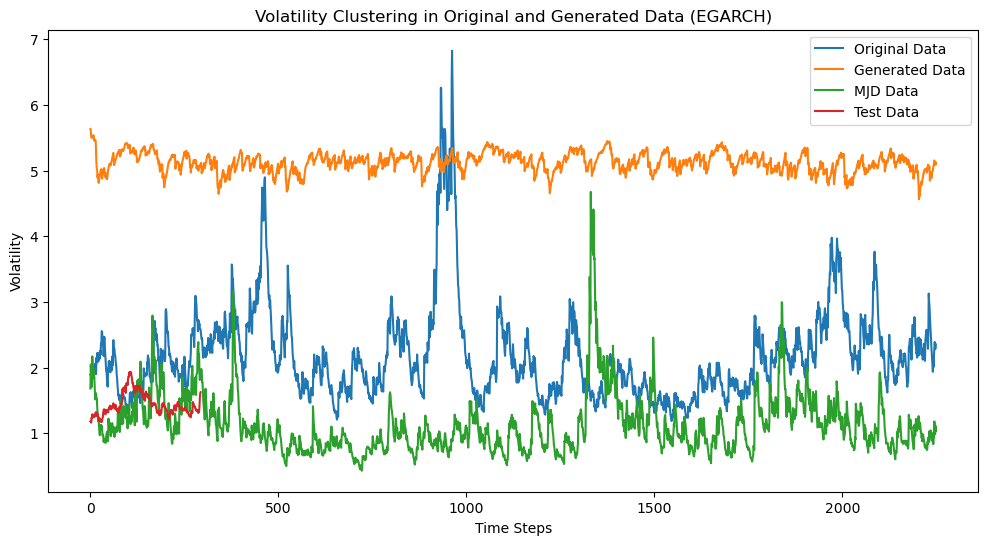

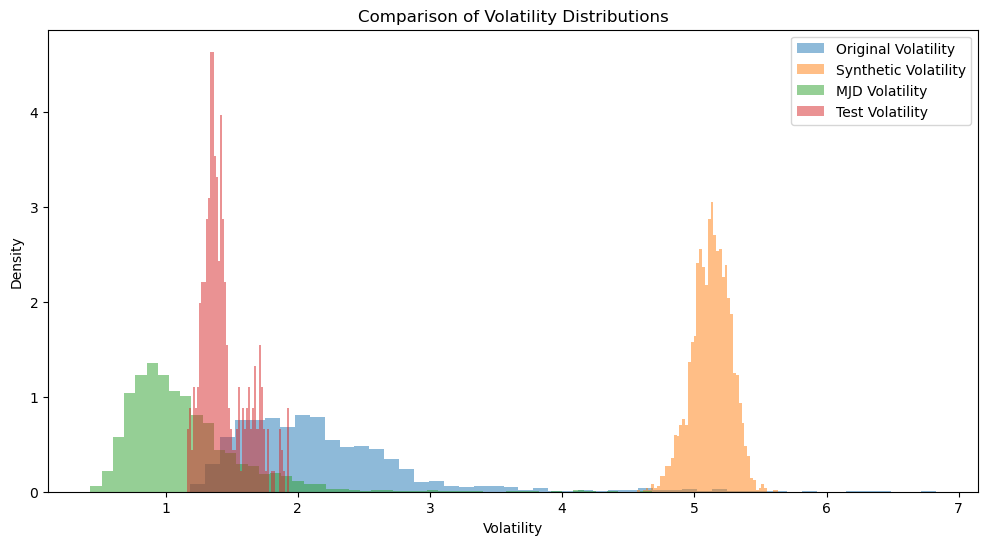

In [307]:
min_length = min(len(log_returns), len(synthetic_log_returns), len(mjd_data))

log_returns = log_returns[:min_length]
synthetic_log_returns = synthetic_log_returns[:min_length]
mjd_data = mjd_data[:min_length]
dates = pd.date_range(start='2015-01-01', periods=len(log_returns), freq='D')
original_df = pd.DataFrame({'log_returns': log_returns}, index=dates)
synthetic_df = pd.DataFrame({'log_returns': synthetic_log_returns}, index=dates)
mjd_df = pd.DataFrame({'log_returns': mjd_data.values.flatten()}, index=dates)
#test_df = pd.DataFrame({'log_returns': test_data}, index=dates)

window_size = 20
original_rolling_volatility = original_df['log_returns'].rolling(window=window_size).std()
synthetic_rolling_volatility = synthetic_df['log_returns'].rolling(window=window_size).std()
mjd_rolling_volatility = mjd_df['log_returns'].rolling(window=window_size).std()
#test_rolling_volatility = test_df['log_returns'].rolling(window=window_size).std()

plt.figure(figsize=(12, 6))
plt.plot(original_rolling_volatility, label='Original Rolling Volatility')
plt.plot(synthetic_rolling_volatility, label='Synthetic Rolling Volatility')
plt.plot(mjd_rolling_volatility, label='MJD Rolling Volatility')
#plt.plot(test_rolling_volatility, label='Test Rolling Volatility')
plt.xlabel('Date')
plt.ylabel('Volatility')
plt.title('Rolling Volatility: Original vs Synthetic')
plt.legend()
plt.show()

rescaled_log_returns = log_returns * 100
rescaled_synthetic_log_returns = synthetic_log_returns * 100
rescaled_mjd_log_returns = mjd_data * 100

original_egarch = arch.arch_model(rescaled_log_returns, vol='EGARCH', p=1, q=1)
original_fit = original_egarch.fit(disp='off')
original_volatility = original_fit.conditional_volatility


synthetic_egarch = arch.arch_model(rescaled_synthetic_log_returns, vol='EGARCH', p=1, q=1)
synthetic_fit = synthetic_egarch.fit(disp='off')
synthetic_volatility = synthetic_fit.conditional_volatility

mjd_egarch = arch.arch_model(rescaled_mjd_log_returns, vol='EGARCH', p=1, q=1)
mjd_fit = mjd_egarch.fit(disp='off')
mjd_volatility = mjd_fit.conditional_volatility

test_egarch = arch.arch_model(rescaled_test_data, vol='EGARCH', p=1, q=1)
test_fit = test_egarch.fit(disp='off')
test_volatility = test_fit.conditional_volatility

plt.figure(figsize=(12, 6))
plt.plot(original_volatility, label='Original Data')
plt.plot(synthetic_volatility, label='Generated Data')
plt.plot(mjd_volatility,label='MJD Data')
plt.plot(test_volatility, label='Test Data')
plt.xlabel('Time Steps')
plt.ylabel('Volatility')
plt.title('Volatility Clustering in Original and Generated Data (EGARCH)')
plt.legend()
plt.show()

plt.figure(figsize=(12, 6))
plt.hist(original_volatility, bins=50, alpha=0.5, label='Original Volatility', density=True)
plt.hist(synthetic_volatility, bins=50, alpha=0.5, label='Synthetic Volatility', density=True)
plt.hist(mjd_volatility,bins=50,alpha=0.5,label='MJD Volatility',density=True)
plt.hist(test_volatility, bins=50, alpha=0.5, label='Test Volatility', density=True)
plt.xlabel('Volatility')
plt.ylabel('Density')
plt.title('Comparison of Volatility Distributions')
plt.legend()
plt.show()

In [308]:
original_std = np.std(log_returns)
synthetic_std = np.std(synthetic_log_returns)
mjd_std = np.std(mjd_data)
test_std = np.std(test_data)

original_std = np.std(log_returns)
synthetic_std = np.std(synthetic_log_returns)
mjd_std = np.std(mjd_data.values.flatten())
test_std = np.std(test_data)

original_skew = np.mean((log_returns - np.mean(log_returns))**3) / np.std(log_returns)**3
synthetic_skew = np.mean((synthetic_log_returns - np.mean(synthetic_log_returns))**3) / np.std(synthetic_log_returns)**3
mjd_skew = np.mean((mjd_data.values.flatten() - np.mean(mjd_data.values.flatten()))**3) / np.std(mjd_data.values.flatten())**3
test_skew = np.mean((test_data - np.mean(test_data))**3) / np.std(test_data)**3

original_kurtosis = np.mean((log_returns - np.mean(log_returns))**4) / np.std(log_returns)**4 - 3
synthetic_kurtosis = np.mean((synthetic_log_returns - np.mean(synthetic_log_returns))**4) / np.std(synthetic_log_returns)**4 - 3
mjd_kurtosis = np.mean((mjd_data.values.flatten() - np.mean(mjd_data.values.flatten()))**4) / np.std(mjd_data.values.flatten())**4 - 3
test_kurtosis = np.mean((test_data - np.mean(test_data))**4) / np.std(test_data)**4 - 3

print(f"Original Data: Standard Deviation = {original_std:.4f}, Skewness = {original_skew:.4f}, Excess Kurtosis = {original_kurtosis:.4f}")
print(f"Synthetic Data: Standard Deviation = {synthetic_std:.4f}, Skewness = {synthetic_skew:.4f}, Excess Kurtosis = {synthetic_kurtosis:.4f}")
print(f"MJD Data: Standard Deviation = {mjd_std:.4f}, Skewness = {mjd_skew:.4f}, Excess Kurtosis = {mjd_kurtosis:.4f}")
print(f"Test Data: Standard Deviation = {test_std:.4f}, Skewness = {test_skew:.4f}, Excess Kurtosis = {test_kurtosis:.4f}")

Original Data: Standard Deviation = 0.0233, Skewness = 0.6579, Excess Kurtosis = 8.5395
Synthetic Data: Standard Deviation = 0.0513, Skewness = 1.2153, Excess Kurtosis = 4.1223
MJD Data: Standard Deviation = 0.0124, Skewness = -0.8660, Excess Kurtosis = 11.1168
Test Data: Standard Deviation = 0.0145, Skewness = 0.4577, Excess Kurtosis = 1.0250


/home/sohamd/anaconda3/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3643: FutureWarning: The behavior of DataFrame.std with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return std(axis=axis, dtype=dtype, out=out, ddof=ddof, **kwargs)


In [309]:
def hurst_exponent(log_returns):
    lags = range(2, 20)
    tau = [np.sqrt(np.std(np.subtract(log_returns[lag:], log_returns[:-lag]))) for lag in lags]
    return np.polyfit(np.log(lags), np.log(tau), 1)[0]

hurst_original = hurst_exponent(log_returns)
hurst_synthetic = hurst_exponent(synthetic_log_returns)
hurst_mjd = hurst_exponent(mjd_data.values.flatten())
hurst_test = hurst_exponent(test_data)

print(f"Original Data: Hurst Exponent = {hurst_original:.4f}")
print(f"Synthetic Data: Hurst Exponent = {hurst_synthetic:.4f}")
print(f"MJD Data: Hurst Exponent = {hurst_mjd:.4f}")
print(f"Test Data: Hurst Exponent = {hurst_test:.4f}")

Original Data: Hurst Exponent = 0.0014
Synthetic Data: Hurst Exponent = 0.0009
MJD Data: Hurst Exponent = 0.0019
Test Data: Hurst Exponent = -0.0022


mu         -0.070747
omega       0.199968
alpha[1]    0.067301
alpha[2]    0.054338
beta[1]     0.569216
beta[2]     0.272241
Name: params, dtype: float64
mu          8.249994e-01
omega       2.624343e+01
alpha[1]    1.744764e-11
alpha[2]    3.674304e-03
beta[1]     0.000000e+00
beta[2]     0.000000e+00
Name: params, dtype: float64


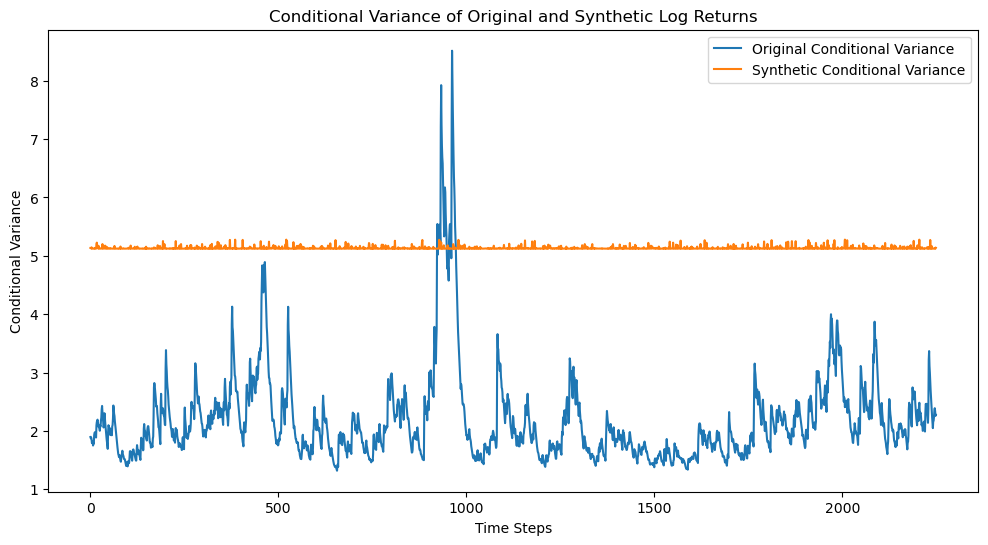

In [310]:
rescaled_log_returns = log_returns * 100
rescaled_synthetic_log_returns = synthetic_log_returns * 100


original_garch = arch.arch_model(rescaled_log_returns, vol='Garch', p=2, q=2)
original_fit = original_garch.fit(disp='off')
original_conditional_variance = original_fit.conditional_volatility


synthetic_garch = arch.arch_model(rescaled_synthetic_log_returns, vol='Garch', p=2, q=2)
synthetic_fit = synthetic_garch.fit(disp='off')
synthetic_conditional_variance = synthetic_fit.conditional_volatility



print(original_fit.params)
print(synthetic_fit.params)


# Plot the conditional variances
plt.figure(figsize=(12, 6))
plt.plot(original_conditional_variance, label='Original Conditional Variance')
plt.plot(synthetic_conditional_variance, label='Synthetic Conditional Variance')
plt.xlabel('Time Steps')
plt.ylabel('Conditional Variance')
plt.title('Conditional Variance of Original and Synthetic Log Returns')
plt.legend()
plt.show()

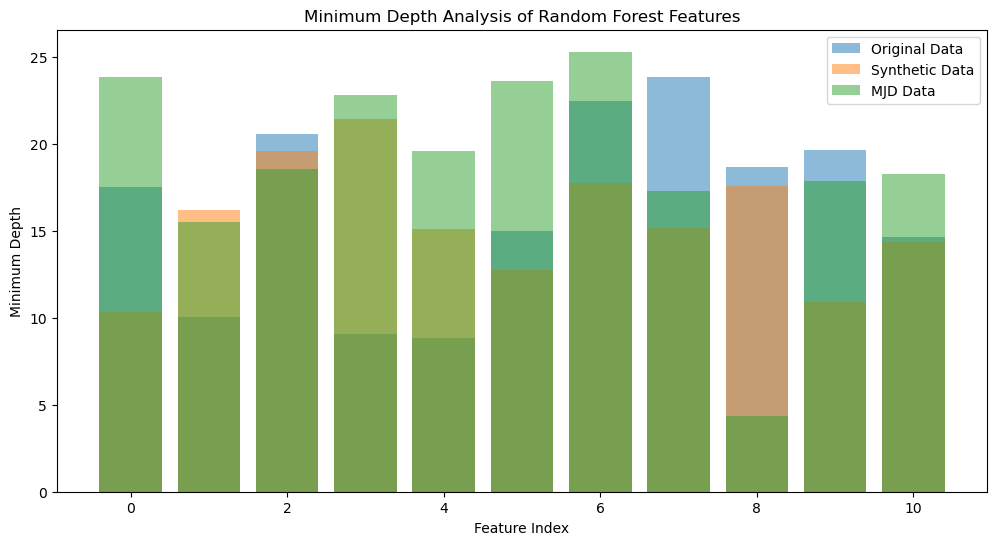

In [311]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split


def create_features(log_returns, window_size=5):
    X, y = [], []
    for i in range(len(log_returns) - window_size):
        X.append(log_returns[i:i + window_size])
        y.append(log_returns[i + window_size])
    return np.array(X), np.array(y)

window_size = 11
X_original, y_original = create_features(log_returns, window_size)
X_synthetic, y_synthetic = create_features(synthetic_log_returns, window_size)
X_mjd, y_mjd = create_features(mjd_data.values.flatten(), window_size)


X_train_original, X_test_original, y_train_original, y_test_original = train_test_split(X_original, y_original, test_size=0.2, random_state=42)
X_train_synthetic, X_test_synthetic, y_train_synthetic, y_test_synthetic = train_test_split(X_synthetic, y_synthetic, test_size=0.2, random_state=42)
X_train_mjd, X_test_mjd, y_train_mjd, y_test_mjd = train_test_split(X_mjd, y_mjd, test_size=0.2, random_state=42)

rf_original = RandomForestRegressor(n_estimators=100, random_state=42)
rf_original.fit(X_train_original, y_train_original)


rf_synthetic = RandomForestRegressor(n_estimators=100, random_state=42)
rf_synthetic.fit(X_train_synthetic, y_train_synthetic)

rf_mjd = RandomForestRegressor(n_estimators=100, random_state=42)
rf_mjd.fit(X_train_mjd, y_train_mjd)

# Analyze minimum depth
def minimum_depth_analysis(rf, X_train):
    min_depth = {i: [] for i in range(X_train.shape[1])}
    for tree in rf.estimators_:
        for i in range(X_train.shape[1]):
            depth = tree.tree_.feature == i
            if np.any(depth):
                min_depth[i].append(np.min(np.where(depth)[0]))
    return {k: np.mean(v) for k, v in min_depth.items()}

min_depth_original = minimum_depth_analysis(rf_original, X_train_original)
min_depth_synthetic = minimum_depth_analysis(rf_synthetic, X_train_synthetic)
min_depth_mjd = minimum_depth_analysis(rf_mjd, X_train_mjd)

plt.figure(figsize=(12, 6))
plt.bar(range(window_size), [min_depth_original[i] for i in range(window_size)], alpha=0.5, label='Original Data')
plt.bar(range(window_size), [min_depth_synthetic[i] for i in range(window_size)], alpha=0.5, label='Synthetic Data')
plt.bar(range(window_size), [min_depth_mjd[i] for i in range(window_size)], alpha=0.5, label='MJD Data')
plt.xlabel('Feature Index')
plt.ylabel('Minimum Depth')
plt.title('Minimum Depth Analysis of Random Forest Features')
plt.legend()
plt.show()

-0.03327491030084525
-0.06480341272241168
-0.019918792422463777


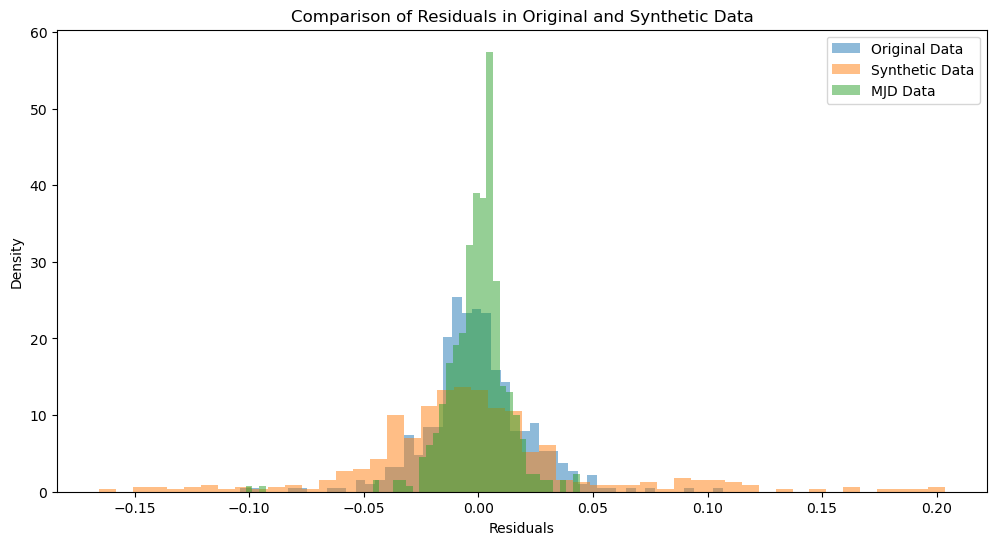

In [312]:
def value_at_risk(rf, X_test, y_test, alpha=0.05):
    y_pred = rf.predict(X_test)
    residuals = y_test - y_pred
    return np.quantile(residuals, alpha)

original_var = value_at_risk(rf_original, X_test_original, y_test_original)
synthetic_var = value_at_risk(rf_synthetic, X_test_synthetic, y_test_synthetic)
mjd_var = value_at_risk(rf_mjd, X_test_mjd, y_test_mjd)

print(original_var)
print(synthetic_var)
print(mjd_var)

plt.figure(figsize=(12, 6))
plt.hist(y_test_original - rf_original.predict(X_test_original), bins=50, alpha=0.5, label='Original Data', density=True)
plt.hist(y_test_synthetic - rf_synthetic.predict(X_test_synthetic), bins=50, alpha=0.5, label='Synthetic Data', density=True)
plt.hist(y_test_mjd - rf_mjd.predict(X_test_mjd), bins=50, alpha=0.5, label='MJD Data', density=True)
plt.xlabel('Residuals')
plt.ylabel('Density')
plt.title('Comparison of Residuals in Original and Synthetic Data')
plt.legend()
plt.show()

<Figure size 1200x600 with 0 Axes>

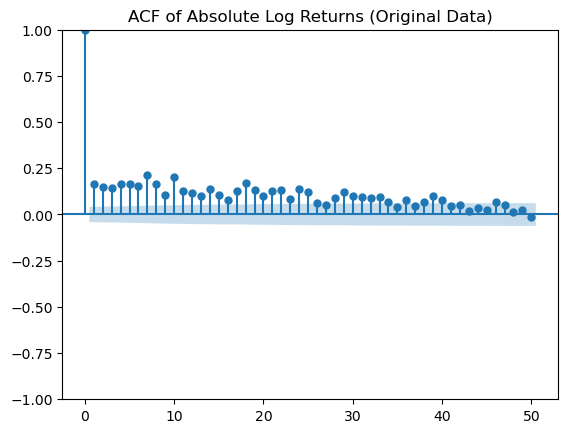

<Figure size 1200x600 with 0 Axes>

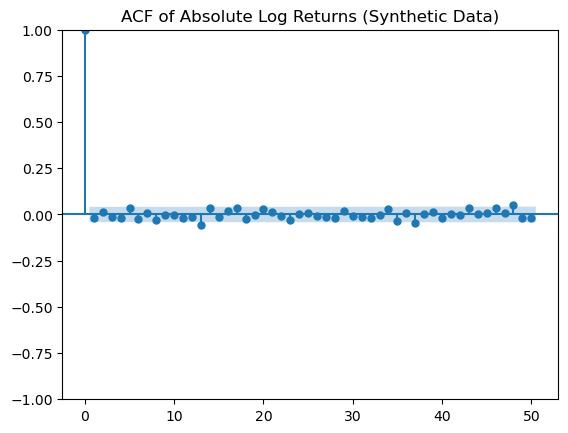

<Figure size 1200x600 with 0 Axes>

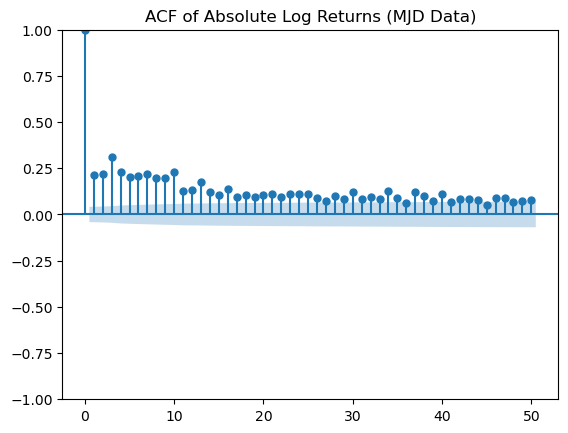

In [313]:
from statsmodels.graphics.tsaplots import plot_acf

plt.figure(figsize=(12, 6))
plot_acf(np.abs(log_returns), lags=50, title='ACF of Absolute Log Returns (Original Data)')
plt.show()

plt.figure(figsize=(12, 6))
plot_acf(np.abs(synthetic_log_returns), lags=50, title='ACF of Absolute Log Returns (Synthetic Data)')
plt.show()

plt.figure(figsize=(12, 6))
plot_acf(np.abs(mjd_data.values.flatten()), lags=50, title='ACF of Absolute Log Returns (MJD Data)')
plt.show()

In [314]:
from scipy.stats import wasserstein_distance

print(wasserstein_distance(log_returns, synthetic_log_returns))
print(wasserstein_distance(log_returns, mjd_data.values.flatten()))


0.016174533415348406
0.008032930869472753


In [315]:
def calculate_var_cvar(paths, alpha=0.05):
    # Calculate the final portfolio values
    portfolio_values = paths[:, -1]
    # Calculate the VaR
    var = np.percentile(portfolio_values, alpha * 100)
    # Calculate the CVaR
    cvar = portfolio_values[portfolio_values <= var].mean()
    return var, cvar

var, cvar = calculate_var_cvar(paths)
print(f"VaR at 5% confidence level: {var:.2f}")
print(f"CVaR at 5% confidence level: {cvar:.2f}")

VaR at 5% confidence level: 14438.23
CVaR at 5% confidence level: 10469.41


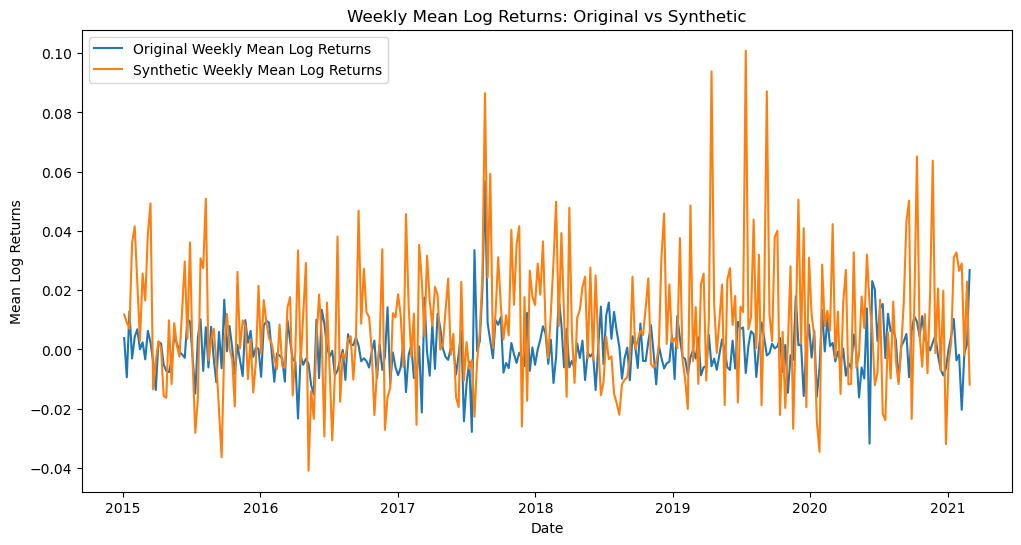

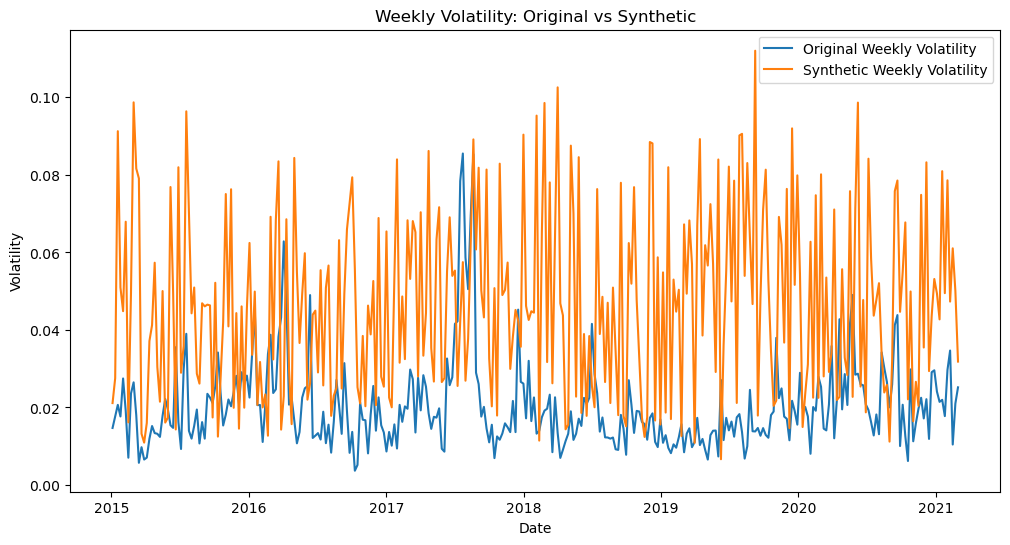

<Figure size 1200x600 with 0 Axes>

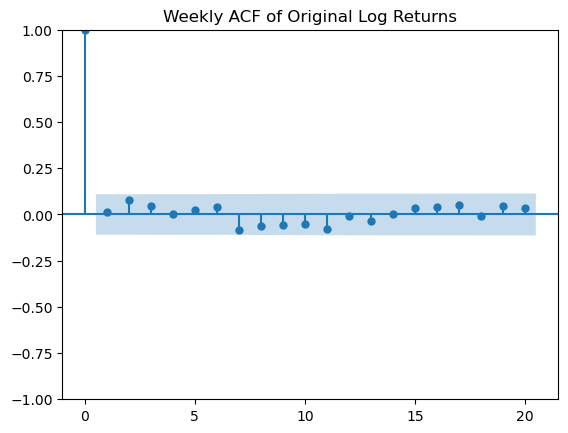

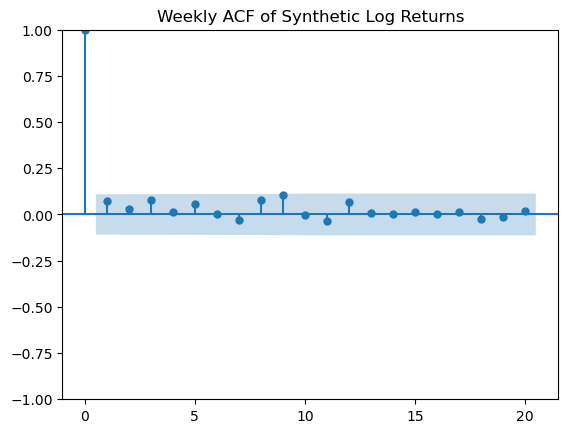

In [316]:
import statsmodels.api as sm

synthetic_log_returns = generate_synthetic_log_returns(params, bins, len(log_returns))
dates = pd.date_range(start='2015-01-01', periods=len(log_returns), freq='D')

original_df = pd.DataFrame({'log_returns': log_returns}, index=dates)
synthetic_df = pd.DataFrame({'log_returns': synthetic_log_returns}, index=dates)

original_weekly = original_df.resample('W').mean()
synthetic_weekly = synthetic_df.resample('W').mean()

plt.figure(figsize=(12, 6))
plt.plot(original_weekly, label='Original Weekly Mean Log Returns')
plt.plot(synthetic_weekly, label='Synthetic Weekly Mean Log Returns')
plt.xlabel('Date')
plt.ylabel('Mean Log Returns')
plt.title('Weekly Mean Log Returns: Original vs Synthetic')
plt.legend()
plt.show()

original_weekly_volatility = original_df.resample('W').std()
synthetic_weekly_volatility = synthetic_df.resample('W').std()

plt.figure(figsize=(12, 6))
plt.plot(original_weekly_volatility, label='Original Weekly Volatility')
plt.plot(synthetic_weekly_volatility, label='Synthetic Weekly Volatility')
plt.xlabel('Date')
plt.ylabel('Volatility')
plt.title('Weekly Volatility: Original vs Synthetic')
plt.legend()
plt.show()

plt.figure(figsize=(12, 6))
sm.graphics.tsa.plot_acf(original_weekly, lags=20, alpha=0.05, title='Weekly ACF of Original Log Returns')
sm.graphics.tsa.plot_acf(synthetic_weekly, lags=20, alpha=0.05, title='Weekly ACF of Synthetic Log Returns')
plt.show()

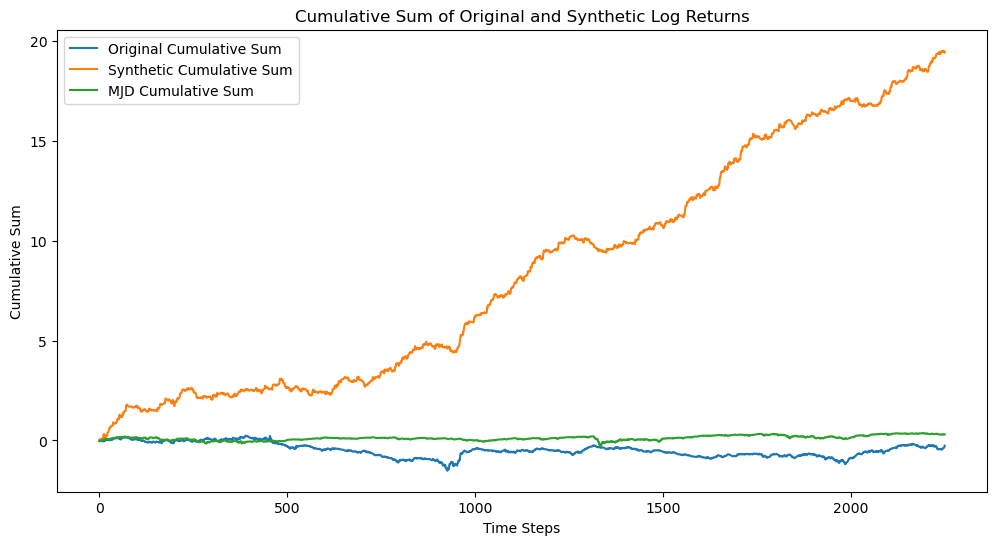

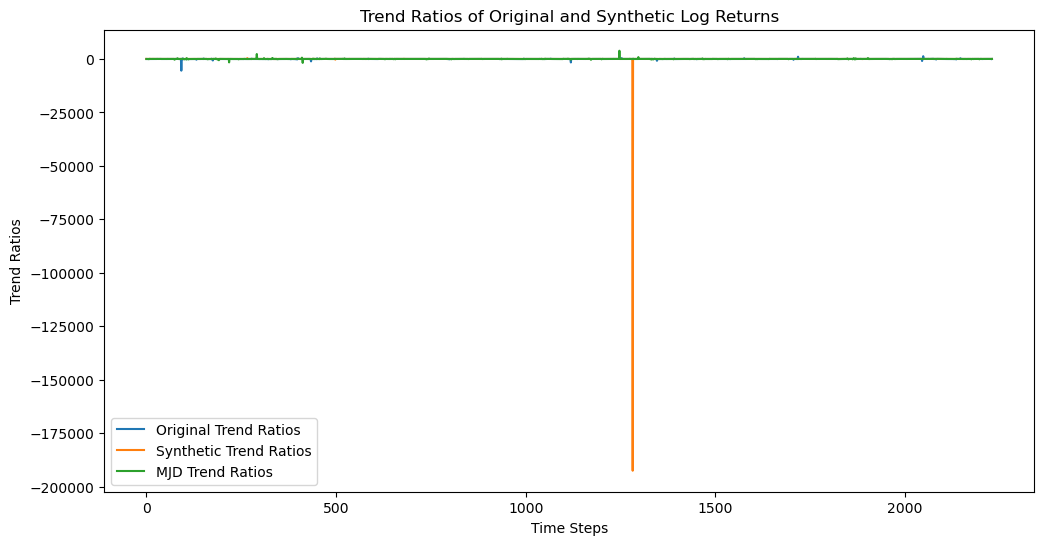

In [317]:
cumulative_sum_original = np.cumsum(log_returns)
cumulative_sum_synthetic = np.cumsum(synthetic_log_returns)
cumulative_sum_mjd = np.cumsum(mjd_data.values.flatten())

plt.figure(figsize=(12, 6))
plt.plot(cumulative_sum_original, label='Original Cumulative Sum')
plt.plot(cumulative_sum_synthetic, label='Synthetic Cumulative Sum')
plt.plot(cumulative_sum_mjd, label='MJD Cumulative Sum')
plt.xlabel('Time Steps')
plt.ylabel('Cumulative Sum')
plt.title('Cumulative Sum of Original and Synthetic Log Returns')
plt.legend()
plt.show()

# Trend Ratios
def trend_ratios(cumulative_sum, lookback=20):
    trend_ratios = []
    for i in range(lookback, len(cumulative_sum)):
        trend = cumulative_sum[i] / cumulative_sum[i - lookback] - 1
        noise = np.mean([cumulative_sum[k] / cumulative_sum[k - 1] - 1 for k in range(i - lookback + 1, i + 1)])
        trend_ratios.append(trend / noise)
    return trend_ratios

trend_ratios_original = trend_ratios(cumulative_sum_original)
trend_ratios_synthetic = trend_ratios(cumulative_sum_synthetic)
trend_ratios_mjd = trend_ratios(cumulative_sum_mjd)

plt.figure(figsize=(12, 6))
plt.plot(trend_ratios_original, label='Original Trend Ratios')
plt.plot(trend_ratios_synthetic, label='Synthetic Trend Ratios')
plt.plot(trend_ratios_mjd, label='MJD Trend Ratios')
plt.xlabel('Time Steps')
plt.ylabel('Trend Ratios')
plt.title('Trend Ratios of Original and Synthetic Log Returns')
plt.legend()
plt.show()

In [318]:
def symmetric_returns(log_returns):
    return np.mean(log_returns ** 2) / np.mean(np.abs(log_returns))

symmetric_original = symmetric_returns(log_returns)
symmetric_synthetic = symmetric_returns(synthetic_log_returns)
symmetric_mjd = symmetric_returns(mjd_data.values.flatten())

print(f"Original Data: Symmetric Returns = {symmetric_original:.4f}")
print(f"Synthetic Data: Symmetric Returns = {symmetric_synthetic:.4f}")
print(f"MJD Data: Symmetric Returns = {symmetric_mjd:.4f}")

Original Data: Symmetric Returns = 0.0333
Synthetic Data: Symmetric Returns = 0.0876
MJD Data: Symmetric Returns = 0.0184


In [325]:
def tail_statistics(log_returns, alpha=0.05):
    return np.percentile(log_returns, [alpha * 100, 95, 90])

tail_original = tail_statistics(log_returns)
tail_synthetic = tail_statistics(synthetic_log_returns)
tail_mjd = tail_statistics(mjd_data.values.flatten())

print(f"Original Data: 1% Quantile = {tail_original[0]:.4f}, 5% Quantile = {tail_original[1]:.4f}, 10% Quantile = {tail_original[2]:.4f}")
print(f"Synthetic Data: 1% Quantile = {tail_synthetic[0]:.4f}, 5% Quantile = {tail_synthetic[1]:.4f}, 10% Quantile = {tail_synthetic[2]:.4f}")
print(f"MJD Data: 1% Quantile = {tail_mjd[0]:.4f}, 5% Quantile = {tail_mjd[1]:.4f}, 10% Quantile = {tail_mjd[2]:.4f}")

Original Data: 1% Quantile = -0.0337, 5% Quantile = 0.0367, 10% Quantile = 0.0269
Synthetic Data: 1% Quantile = -0.0530, 5% Quantile = 0.1130, 10% Quantile = 0.0410
MJD Data: 1% Quantile = -0.0257, 5% Quantile = 0.0249, 10% Quantile = 0.0181


In [332]:
def compute_var_es(data, quantile):
    var = np.percentile(data, quantile)
    es = data[data <= var].mean()
    return var, es

def tailrisktest(original_data, simulated_data, quantiles=[1, 5]):
    results = {}
    
    for quantile in quantiles:
        var_original, es_original = compute_var_es(original_data, quantile)
        var_simulated, es_simulated = compute_var_es(simulated_data, quantile)
        
        results[quantile] = {
            'VaR_Original': var_original,
            'ES_Original': es_original,
            'VaR_Simulated': var_simulated,
            'ES_Simulated': es_simulated
        }
        
        print(f"Quantile: {quantile}%")
        print(f"Original Data - VaR: {var_original:.4f}, CVaR: {es_original:.4f}")
        print(f"Simulated Data - VaR: {var_simulated:.4f}, CVaR: {es_simulated:.4f}")
        print()
    
    return results

print("QCBM Results")
covid_data = pd.read_csv('brnt_data_test.csv')
covid_data['Price'] = covid_data['Price'].astype(str)
covid_prices = pd.to_numeric(covid_data['Price'].str.replace(',', ''), errors='coerce').dropna().values
covid_log_returns = np.diff(np.log(covid_prices))

results_synthetic = tailrisktest(covid_log_returns, generate_synthetic_log_returns(load_params(params_file), bins, len(covid_log_returns)))
print("------------------")
print("MJD Results")
results_mjd = tailrisktest(covid_log_returns, mjd_data.values.flatten())

QCBM Results
Quantile: 1%
Original Data - VaR: -0.0305, CVaR: -0.0355
Simulated Data - VaR: -0.1039, CVaR: -0.1133

Quantile: 5%
Original Data - VaR: -0.0241, CVaR: -0.0278
Simulated Data - VaR: -0.0525, CVaR: -0.0910

------------------
MJD Results
Quantile: 1%
Original Data - VaR: -0.0305, CVaR: -0.0355
Simulated Data - VaR: -0.0379, CVaR: -0.0459

Quantile: 5%
Original Data - VaR: -0.0241, CVaR: -0.0278
Simulated Data - VaR: -0.0257, CVaR: -0.0351



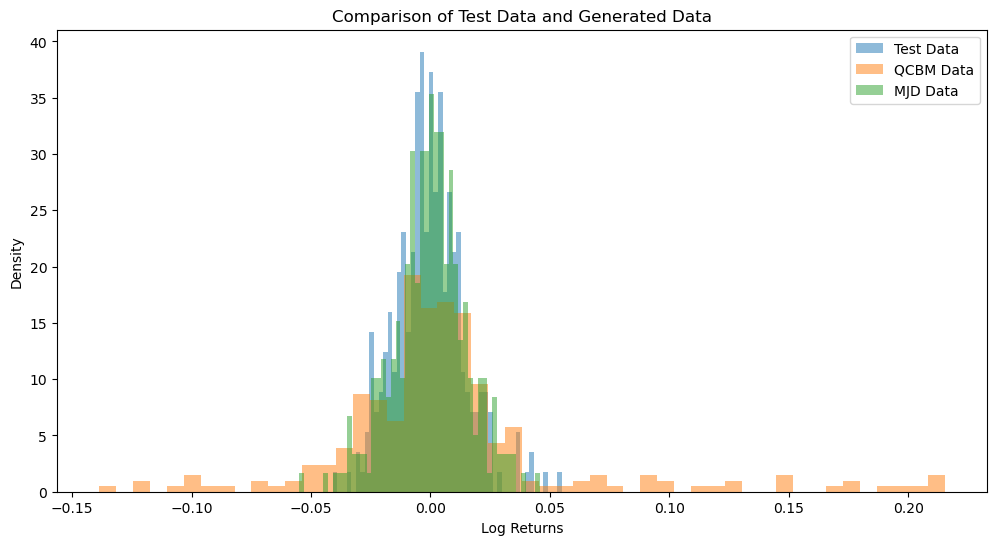

In [333]:
# compare the distributions of the mjd model and the qcbm model against the test data
plt.figure(figsize=(12, 6))
plt.hist(test_data[0], bins=50, alpha=0.5, label='Test Data', density=True)
plt.hist(synthetic_log_returns, bins=50, alpha=0.5, label='QCBM Data', density=True)
plt.hist(mjd_data, bins=50, alpha=0.5, label='MJD Data', density=True)
plt.xlabel('Log Returns')
plt.ylabel('Density')
plt.title('Comparison of Test Data and Generated Data')
plt.legend()
plt.show()

In [334]:
test_data = load_and_preprocess_data("brnt_data_test.csv")

synthetic_log_returns = generate_synthetic_log_returns(load_params(params_file), bins, len(test_data[0]))
mjd_data = mjd_data[:len(test_data[0])]

print("QCBM Results") 
results_synthetic = tailrisktest(test_data[0], synthetic_log_returns)
print("------------------")
print("MJD Results")  
results_mjd = tailrisktest(test_data[0], mjd_data.values.flatten())


QCBM Results
Quantile: 1%
Original Data - VaR: -0.0305, CVaR: -0.0355
Simulated Data - VaR: -0.0874, CVaR: -0.1116

Quantile: 5%
Original Data - VaR: -0.0241, CVaR: -0.0278
Simulated Data - VaR: -0.0489, CVaR: -0.0705

------------------
MJD Results
Quantile: 1%
Original Data - VaR: -0.0305, CVaR: -0.0355
Simulated Data - VaR: -0.0379, CVaR: -0.0459

Quantile: 5%
Original Data - VaR: -0.0241, CVaR: -0.0278
Simulated Data - VaR: -0.0257, CVaR: -0.0351

